# User Guide 2: Understanding the data and The is_simulation Function
## Introduction

In Guide 1, we ran our first importsance sampling simulation using [PyFPT](https://github.com/Jacks0nJ/PyFPT). It was applied to quadratic inflation, with the result that the numerically reconstructed probability density deviated from the analytical expectation in the tail of the distribution. This comparison was done using the analytics module of PyFPT.

However, we treated the numerical results of the PyFPT package as a blackbox and used the default values. In this Notebook, we will look at better understanding the simulated data, and also introduce some of the optional arguments for `fpt.numerics.is_simulation`. The aim is to start to demystify `fpt.numerics.is_simulation`. To further this aim, if a new optional argument is introduce used, it will be specified in the section heading as well. The rest of optional arguemtents will be introduced in the following guides in a similair manner.

Once this is done, we will use this knowledge to combine data sets to numerically reconstruct the probability density from the peak of the distribution all the way into the very rare events in the far tail.

### Context - Importance Sampling
Importance sampling is achieved by a introducing a bias to the slow-roll Langevin equation to over sample the large $\mathcal{N}$

$$
\frac{{\rm d} \phi}{{\rm d} N} =  \underbrace{-\frac{1}{3H^2(\phi)} \frac{{\rm d} V(\phi)}{{\rm d} \phi}+\frac{H(\phi)}{2\pi}\xi}_{{\rm Unmodified} \; {\rm Langevin} \; {\rm Equation}}+\underbrace{\mathcal{B}(\phi)}_{Bias} \, ,
$$

where $H$ is the Hubble parameter, $\xi$ is a unit variance Gaussian white noise and $\mathcal{B}$ is the bias introduced. You can this imagine bias as a wind pushing against the drift term (the first term above), meaning it takes longer for the field $\phi$ to evolve from $\phi_i$ to $\phi_{\rm end}$. Therefore the probability of a run having a long FPT $\mathcal{N}$, and thus a large curvature perturbation by the stochastic $\delta N$-formalism, is greater.

There is a choice in the functional form of the bias $\mathcal{B}(\phi)$ used. A simple choice is to have it proportinal to diffusion,

$$
\mathcal{B}(\phi) = \mathcal{A} \frac{H(\phi)}{2\pi} \, ,
$$

where the parameter $\mathcal{A}$, known as the bias amplitude, can be used to tune how strong the bias is. This is the only option in currently available `fpt.numerics.is_simulation` but in future editions a general function as an argument will be allowed.

Of course, the above Lanegvin equation results in a slightly different stochastic path than if no bias was present. The relative probability that this stochastic path is achieved without $\mathcal{B}$ being present then gives the statistical weight of this realisation of the Langevin equation. For the biased Langevin equation above and discrete steps $\Delta N$ steps, which resulted in the path $\mathbf{Y} = (\phi_1, \phi_2,...\phi_{M})$ of $M$ steps starting at $\phi_i$, the weight is

$$
w(\mathbf{Y}) = \frac{p_T(\mathbf{Y}|\phi_i)}{p_S(\mathbf{Y}|\phi_i)} \, ,
$$
where $p_T$ denotes the probability of the path in the original target distribution (no bias), and $p_S$ denotes its probability in the modified sample distribution (biased).


Knowing the value of $w$ for each path then allows $P(\mathcal{N})$ to estimated. 


## Plotting the Raw Data (`save_data`)

Previously, we only plotted the already processed $P(\mathcal{N})$ data. As importance sampling alone results in two data sets, one for the FPTs $\mathcal{N}$ and another for associated weights $w$ of this sampled paths, one needs to use data processing. 

To do this, lets first understand the relation $\mathcal{N}$ and $w$. This is most easily done using a 2D histogram and requires that the raw $\mathcal{N}$ and $w$ data is saved when `fpt.numerics.is_simulation` is run. We can do this using the optional argument `save_data`. As before, we will also import the other packages we need and define the potential first.

In [1]:
import pyfpt as fpt
import numpy as np
import matplotlib.pyplot as plt

import mpl_style
plt.style.use(mpl_style.paper_style)

# Will also need pandas to read saved raw the data
import pandas as pd
# Also need colours for a 2D histogram
from matplotlib.colors import LogNorm



In [3]:
phi_i = 42**0.5
phi_end = 2**0.5

# For the above phi_i, this mass is the interim case.
m = 0.1


# Any slow-roll potential and its derivatives could be defined here
def V(phi):
    V = 0.5*(m*phi)**2
    return V


def V_dif(phi):
    V_dif = (m**2)*phi
    return V_dif


def V_ddif(phi):
    V_ddif = (m**2)
    return V_ddif


In [4]:
# The number of simulation runs
num_runs = 10**5
bias_amp = 1.

Now let's run the same simulation as before, but save the raw $\mathcal{N}$ and $w$ data this time.

In [6]:
# Returns the normalised histogram bin centres, heights and
# errors as a lists. Optional argument given to save raw data.
bin_centres, heights, errors =\
    fpt.numerics.is_simulation(V, V_dif, V_ddif, phi_i, phi_end, num_runs,
                               bias_amp, save_data=True)


# Easier to use numpy arrays rather than lists
bin_centres = np.array(bin_centres)
heights = np.array(heights)
errors = np.array(errors)

Number of cores used: 4
The simulations took: 98.55488285599859 seconds
Saved data to file IS_data_phi_i_6.48_iterations_100000_bias_1.0.csv


The raw data was saved to a comma seperated value (.csv) file using pandas called "IS_data_phi_i_6.48_iterations_100000_bias_1.0.csv" in the same directory as this Notebook.

Now we can again use pandas to read the data from the file

In [11]:
raw_data = pd.read_csv('IS_data_phi_i_6.48_iterations_100000_bias_1.0.csv', index_col=0)

# Easier to work with NumPy arrays
N_values = np.array(raw_data['N'])
w_values = np.array(raw_data['w'])


We can now do let's do a 2H histogram as a colour map.

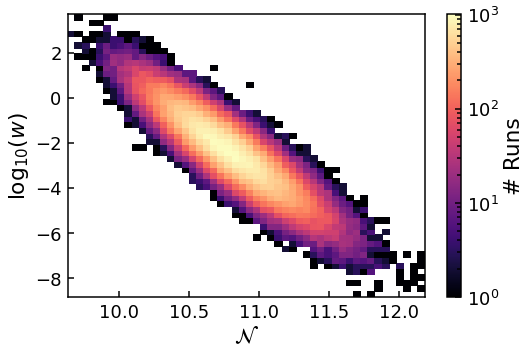

<Figure size 576x374.4 with 0 Axes>

In [15]:
plt.hist2d(N_values, np.log10(w_values), (50, 50), norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'# Runs')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'${\rm log}_{10}(w)$')
plt.show()
plt.clf()

#### Interpreting the Data and Lognormal Method (`estimator`)

Clearly, there is not a one-to-one relation between the FPT in e-folds of an importance sampling simulation run $\mathcal{N}$ and its weight $w$. Instead, there is a correlation between ${\rm log}_{10}(w)$ and $\mathcal{N}$, with the majority of the data at the centre. This means that within any particular $\mathcal{N}$ bin, $w$ can vary by orders of magnitude. As we have a finite number of data points within each bin and na&#239;vly the value of $P(\mathcal{N})$ is just the normalsied sum of the $w$s within the bin, how can we accurately estimate $P(\mathcal{N})$? As surely the sum will be dominated just by the few largest $w$ values?

The answer is to use the fact that $w$ follows a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), meaning $\ln (w)$ follows normal (Gaussian) distribution. See JOE ADD IS PAPER for explaination of why this is. Therefore, if can calculate the mean and variance of $\ln (w)$, denoted as $\mu$ and $\sigma$ respectively, then the mean of $w$ is given by

$$
\nu = \exp \bigg( {\mu + \frac{\sigma^2}{2}} \bigg) \, .
$$

The sum of $w$ with a particular bin is then (by the definition of the mean)

$$
w = n \nu \, ,
$$

where $n$ is the number of runs within the bin of interest. This method has the advantage that it utilises all of the data equally and is therefore not domiated by the few largest $w$ values.


The lognormal assumption is the default estimator used in `fpt.numerics.is_simulation`, i.e. `estimator='lognormal'` is the default argument. One can also use `estimator='naive'` for the na&#239;ve estimator.

## Combining Data Sets

An important point to obersve in the 2D histogram above, is that the mean of the sampled $\mathcal{N}$ is centred around $\sim 10.8$ but the mean of the target distribution, due to the $\phi_i$ value used, is 10. Therefore, the sample distribution is simply shifted compared to the target distribution. It is the value of the weights which reconstructs the target distribution and is most accurately reconstrcuted about the mean of the sample distribution.

Put simply, for $m=0.1$ used here, as the bias amplitude $\mathcal{A}$ is increased, PyFPT probes further and further into the tail of $P(\mathcal{N})$. This leads to the question, could we run a series of simulations sets of increasing $\mathcal{A}$ and combine. The answer is: yes we can!



### Storing Results and Loops (`bins`)

To plot the results from multiple importance samples, we need to run multiple importance samples and store the data. This can be done using a `for` loop and empty NumPy arrays.

But first, we need to define what our range of bias amplitudes will be. Note I've include a value of zero, to allow comparison with a direct simulation with no importance sampling.

In [5]:
bias_amp_range = np.array([0., 1., 2., 3.])

Now let's set up empty arrays to store the results. To do this we need to know the length of the returned data lists, which corresponds to the number of bins used in the histogram of $\mathcal{N}$. There is optional argument for `fpt.numerics.is_simulation` called `bins`. If `bins` is an integer, this is simply the number of evenly spaced bins used. If bins is a list or numpy array, it defines the bin edges, including the left edge of the first bin and the right edge of the last bin. The widths can vary. The default is 50 evenly spaced bins, i.e. `bins=50` in `fpt.numerics.is_simulation`, which was found in practise to be a good descriptor of the data but we will still pass this as an argument for clarity.

As we know the size of the returned lists and the number of them, storage arrays can be defined.

In [6]:
num_bins = 50 # Number of evenly spaced bins used in the histogram

# Empty arrays to store values
bin_centres_storage = np.zeros((num_bins,len(bias_amp_range)))
heights_storage = np.zeros((num_bins,len(bias_amp_range)))

# Errors are asymmetric, so need a 3D array as each `error' has two values
errors_storage = np.zeros((len(bias_amp_range), 2, num_bins))

A `for` loop can be used to run a set of runs for each bias value in `bias_amp_range`. 

Now simulating for bias amplitude 0.0
Number of cores used: 4
The simulations took: 85.20950597900082 seconds
Saved data to file IS_data_phi_i_6.48_iterations_100000_bias_0.0.csv
Now simulating for bias amplitude 1.0
Number of cores used: 4
The simulations took: 101.19991613099955 seconds
Saved data to file IS_data_phi_i_6.48_iterations_100000_bias_1.0.csv
Possibly not lognormal distribution, see p-value plots


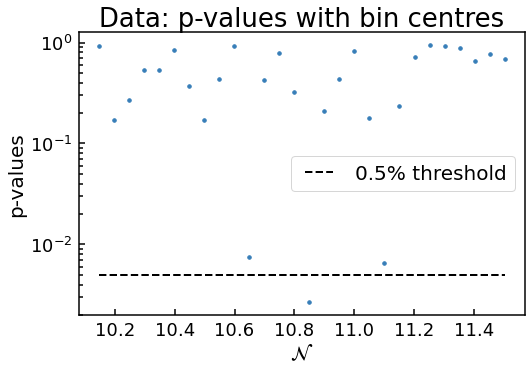

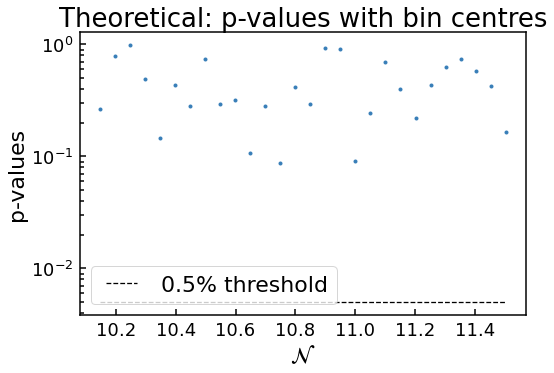

Now simulating for bias amplitude 2.0
Number of cores used: 4
The simulations took: 113.49233079899932 seconds
Saved data to file IS_data_phi_i_6.48_iterations_100000_bias_2.0.csv
Now simulating for bias amplitude 3.0
Number of cores used: 4
The simulations took: 115.43625862200133 seconds
Saved data to file IS_data_phi_i_6.48_iterations_100000_bias_3.0.csv


In [11]:
for i, bias_amp in enumerate(bias_amp_range):
    print('Now simulating for bias amplitude '+str(bias_amp))
    bin_centres, heights, errors =\
        fpt.numerics.is_simulation(V, V_dif, V_ddif, phi_i, phi_end,
                                   num_runs, bias_amp, save_data=True,
                                   estimator='lognormal', bins=num_bins)
    
    # Storing the results in NumPy arrays
    bin_centres_storage[:len(bin_centres),i] = bin_centres
    heights_storage[:len(heights),i] = heights
    # Remeber this is a 3D array
    errors_storage[i,:,:len(heights)] = errors


#### Context - p-values Plots

Notice how two plots were outputted for the simulation with `bias_amp` of 1? This is because one of the $p$-values (which is the probability that the data is drawn from an underlying lognormal distribution) for the $w$ values in the $\mathcal{N}$ bin near 10.8 is below the 0.5% threshold. This tells the code to check with the user to see if the approximation that the distribution of $w$ within each bin is given by a lognormal distribution. Determing if this is the case can be difficult, as randomly we expect some of the $p$-values to be below the threshold. That's why the theoretical $p$-values, where each bin has $w$ values randomly drawn from a true lognomral distribution, is given for comparison.

For this case, as only one $p$-value is below the threshold and the two plots look very similair, it is safe to say the lognormal approximation is valid. On the other hand, if several $p$-values were samller than $10^{-15}$, it's highly probably the approximation is invalid. This of course requires some judgement of the user, generally as the number of runs is increased, the $p$-values get even smaller if it is NOT a lognormal distribution. So one can just run the simulation again with more runs for these borderline cases.


### Bin Truncation (`min_bin_size`)
Note my use above of `:len(heights)` when storing the results. This is because by default, if any bin with less then 400 runs is truncated and the length of `heights` may be less then the number of bins provided. The truncation is a conservative measure, to make sure only data points where the error estimation is accurate is plotted. But if want to much less conservative and only require, say, 100 runs? This can be done with the optional argument `min_bin_size=100` in `fpt.numerics.is_simulation`. The default is 400.

### Plotting the Combined Data
As we have the results stored, again we can use a `for` loop to over plot all of this data, as well as the Gausiian and Edgeworth approximations.

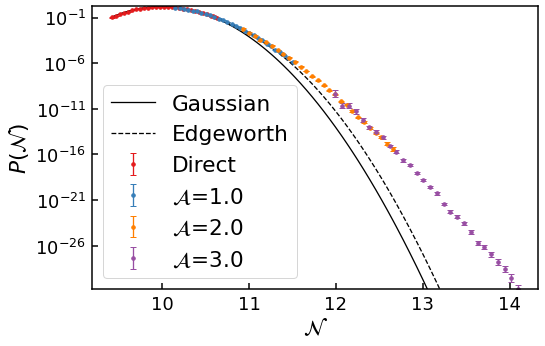

In [29]:
for i, bias_amp in enumerate(bias_amp_range):
    # Slicing the ith data
    bin_centres_temp = bin_centres_storage[:,i]
    heights_temp = heights_storage[:,i]
    # Remeber there are lower and upper errors, so it's a 3D array.
    errors_temp = errors_storage[i,:,:]
    
    # Remove the zero values array padding
    errors_temp = errors_temp[:,heights_temp>0]
    bin_centres_temp = bin_centres_temp[heights_temp>0]
    heights_temp = heights_temp[heights_temp>0]

    # Plotting the direct sample using red
    if round(bias_amp,4) == 0.:
        plt.errorbar(bin_centres_temp, heights_temp, yerr=errors_temp,
                     fmt=".", ms=7, label='{0}'.format(r'Direct'),
                     color = '#e41a1c')
    # The rest of the importance samples use standard colours
    else:
        plt.errorbar(bin_centres_temp, heights_temp, yerr=errors_temp,
                     fmt=".", ms=7, label='{0}'.format(r'$\mathcal{A}$='+str(bias_amp)))
# Analytical functions
gaussian_pdf = fpt.analytics.gaussian_pdf(V, V_dif, V_ddif, phi_i, phi_end)       
edgeworth_pdf = fpt.analytics.edgeworth_pdf(V, V_dif, V_ddif, phi_i, phi_end)

# Need to convert2D to 1D for plotting
bin_centres_combined = bin_centres_storage.flatten()
# Remove the empty values
bin_centres_combined = np.sort(bin_centres_combined[bin_centres_combined>0])

# Plotting analytical expectations
plt.plot(bin_centres_combined, gaussian_pdf(bin_centres_combined),
         label='{0}'.format('Gaussian'), color='k')
plt.plot(bin_centres_combined, edgeworth_pdf(bin_centres_combined),
         label='{0}'.format('Edgeworth'), color='k', linestyle='dashed')

# Smallest y value plotted corresponding to data
plt.ylim(bottom = np.min(heights_storage[heights_storage>0]))


# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.legend()

In the above graph, with a total simulation time of only $\sim 8$ minutes, we have been able to numerically reconstruct the probability density $P(\mathcal{N})$ from the peak of the distribution all the way down to $10^{-31}$! And the resuts overlap too, showing they are self-consistent!


Clearly, the numerical data agrees with the Gaussian and Edgeworth approximations before deviating strongly in the tail. In the far tail, this deviation is very large: the numerical data point at $\mathcal{N}\sim 13$ has a probability density $P(\mathcal{N})$ $10^8$ times larger than the Edgeworth prediction. Discovering this boost to $P(\mathcal{N})$ in the tail is only possible using the method of importance sampling.

### Other Potentials and Masses
We can do the exact same procedure of increasing the bias amplitude $\mathcal{A}$ to probe further and further into the tail for other potentials, just by changing the potential functions `V`, `V_dif` and `V_ddif` defined above, as long as diffusion effects are not dominating. Indeed, for smaller mass $m$, where diffusion effects are very small and the Gaussian prediction should hold far into the tail, PyFPT was able to reproduce this effect.

However, for diffusion domination, the importance sampling technique becomes much less effective, as we will see in the next guide.

## Conclusion
In this guide, we have briefly touched on the method of importance sampling and the raw data it produces, then the different data analysis techniques to reconstruct the probability density $P(\mathcal{N})$. Along the way, we have introduced some of the optional arguments for `fpt.numerics.is_simulation`, allowing us to customize the data analysis. Finally, we used this knowlegde to combine multiple importance samples together to reconstruct $P(\mathcal{N})$ from the peak of the distribution all the way down to $10^{-31}$!


In the next and final guide, we will look at the numerically more difficult diffusion domination case. This will let us introduce the final optional arguments for `fpt.numerics.is_simulation` and analytical tools, as well as discuss some of the limitations of PyFPT.